In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pydot
from   sklearn.model_selection import train_test_split
import tensorflow as tf
from   tensorflow.keras.layers import Dense, Input, Layer
from   tensorflow.keras.metrics import RootMeanSquaredError as RMSE
from   tensorflow.keras.models import Model
from   tensorflow.keras.optimizers import SGD
from   tensorflow.python.keras.utils.vis_utils import plot_model

In [24]:
URL = ('https://archive.ics.uci.edu/ml/machine-learning-databases/00242/'
       'ENB2012_data.xlsx')
VARS = {'X1': 'relative_compactness',
        'X2': 'surface_area',
        'X3': 'wall_area',
        'X4': 'roof_area',
        'X5': 'overall_height',
        'X6': 'orientation',
        'X7': 'glazing_area',
        'X8': 'glazing_area_distribution',
        'Y1': 'heatingLoad',
        'Y2': 'coolingLoad'}
DATA = '../data/energy_efficiency.csv'

In [49]:
ETA = 0.001
EPOCHS = 2000
BATCH = 16

In [18]:
def format_output(data):
    y1 = np.array(data.pop(VARS['Y1']))
    y2 = np.array(data.pop(VARS['Y2']))
    return y1, y2

In [28]:
def norm(x, train_stats):
    return (x - train_stats['mean']) / train_stats['std']

In [79]:
def plot_diff(y, pred, title='', dims=[-100, 100], **kwargs):
    plt.scatter(y, pred, **kwargs)
    plt.title(title)
    plt.xlabel('Ground truth')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.plot(dims, dims, color='r')
    plt.show()

In [87]:
def plot_metrics(history, metric_name, title, ylim=5, **kwargs):
    plt.title(title)
    plt.ylim(0, ylim)
    plt.plot(history.history[metric_name], color='blue', label=metric_name)
    val_metric = f'val_{metric_name}'
    plt.plot(history.history[val_metric], color='red', label=val_metric)
    plt.legend()
    plt.show()

In [57]:
def load_data(path, test_size=0.2):
    df = pd.read_csv(path)
    drop = [col for col in list(df) if col.startswith('Unnamed')]
    df.drop(drop, axis=1, inplace=True)
    df = df.sample(frac=1).reset_index(drop=True) # shuffle
    train, test = train_test_split(df, test_size=test_size)
    train_stats = train.describe()
    train_stats.pop(VARS['Y1'])
    train_stats.pop(VARS['Y2'])
    train_stats = train_stats.transpose()
    train_Y = format_output(train)
    test_Y = format_output(test)
    norm_train_X = norm(train, train_stats)
    norm_test_X = norm(test, train_stats)
    return norm_train_X, train_Y, norm_test_X, test_Y #, train_stats

In [58]:
norm_train_X, train_Y, norm_test_X, test_Y = load_data(DATA)

In [59]:
def build_model(input_shape):
    input_layer = Input(shape=input_shape)
    d1 = Dense(128, activation='relu')(input_layer)
    d2 = Dense(128, activation='relu')(d1)
    y1 = Dense(1, name='y1')(d2)
    d3 = Dense(64, activation='relu')(d2)
    y2 = Dense(1, name='y2')(d3)
    mod = Model(inputs=input_layer, outputs=[y1, y2])
    return mod

In [60]:
input_shape = (norm_train_X.shape[1],)
mod = build_model(input_shape)
print(mod.summary())

Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_9 (Dense)                 (None, 128)          1152        input_4[0][0]                    
__________________________________________________________________________________________________
dense_10 (Dense)                (None, 128)          16512       dense_9[0][0]                    
__________________________________________________________________________________________________
dense_11 (Dense)                (None, 64)           8256        dense_10[0][0]                   
_______________________________________________________________________________________

In [61]:
optimizer = SGD(lr=ETA)
mod.compile(optimizer=optimizer, 
            loss={'y1': 'mse', 'y2': 'mse'}, 
            metrics={'y1': RMSE(), 'y2': RMSE()})

In [62]:
# Us. unnecessary, but some versions of TF may insert an empty layer
# that breaks plot_model()
mod._layers = [layer for layer in mod._layers if isinstance(layer, Layer)]

In [63]:
plot_model(mod)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [64]:
plot_model(mod, show_shapes=True, show_layer_names=True, to_file='mod.png')

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


In [67]:
history = mod.fit(norm_train_X, 
                  train_Y, 
                  epochs=EPOCHS, 
                  batch_size=BATCH, 
                  validation_data=(norm_test_X, test_Y),
                  verbose=0)

In [72]:
loss, y1_loss, y2_loss, y1_rmse, y2_rmse = mod.evaluate(x=norm_test_X, 
                                                        y=test_Y)
print(f'\nLoss: {loss:.5f}\n'
      f'Y1:\n  loss: {y1_loss:.5f}, rmse: {y1_rmse:.5f}\n'
      f'Y2:\n        {y2_loss:.5f}        {y2_rmse:.5f}')

5/5 [==============================] - 0s 768us/step - loss: 0.5379 - y1_loss: 0.1972 - y2_loss: 0.3406 - y1_root_mean_squared_error: 0.4441 - y2_root_mean_squared_error: 0.5836

Loss: 0.53786
Y1:
  loss: 0.19725, rmse: 0.44413
Y2:
        0.34061        0.58362


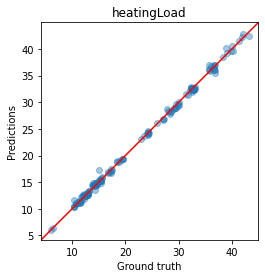

In [80]:
preds = mod.predict(norm_test_X)
plot_diff(test_Y[0], preds[0], title=VARS['Y1'], alpha=0.4)

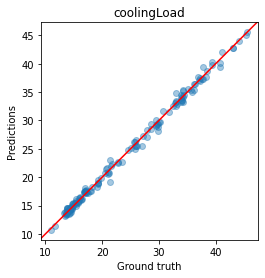

In [81]:
preds = mod.predict(norm_test_X)
plot_diff(test_Y[1], preds[1], title=VARS['Y2'], alpha=0.4)

In [85]:
history.history.keys()

dict_keys(['loss', 'y1_loss', 'y2_loss', 'y1_root_mean_squared_error', 'y2_root_mean_squared_error', 'val_loss', 'val_y1_loss', 'val_y2_loss', 'val_y1_root_mean_squared_error', 'val_y2_root_mean_squared_error'])

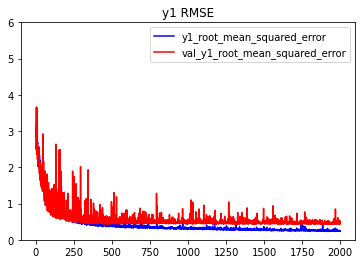

In [88]:
plot_metrics(
    history, 'y1_root_mean_squared_error', title='y1 RMSE', ylim=6)

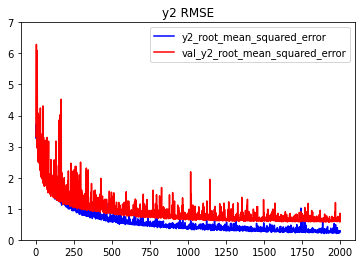

In [90]:
plot_metrics(
    history, 'y2_root_mean_squared_error', title='y2 RMSE', ylim=7)